Understanding the Variational Autoencoder (VAE) Encoder Network
A Variational Autoencoder (VAE) is a type of neural network designed for generating new data that resembles a given dataset. It works by compressing images into a smaller representation (encoding) and then reconstructing them (decoding).

What does this encoder do?
The encoder takes an input image (28x28 grayscale MNIST digit) and compresses it into two vectors:

z_mean: The mean (center) of the latent space distribution
z_log_var: The logarithm of the variance of the latent space distribution
These two values define a probability distribution from which we will sample a new point.

 Imports necessary libraries

tensorflow.keras is the high-level API of TensorFlow used to build neural networks.
layers contains predefined neural network layers.

In [1]:
from tensorflow import keras
from keras import layers

In [2]:
latent_dim=2

Defines the size of the latent space

latent_dim = 2 means that the compressed representation of the image will have 2 dimensions.
The VAE learns a 2D probability distribution, which helps in generating new images.

In [3]:
encoder_inputs=keras.Input(shape=(28,28,1))

Creates an input layer

The shape (28, 28, 1) means:
28 x 28 → Image height and width
1 → Grayscale image (single color channel)

first convolutional layer

In [4]:
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)


 Applies a convolutional layer

Conv2D(32, 3, activation="relu", strides=2, padding="same")
32 → Number of filters (detects patterns like edges)
3 → Filter size is 3x3
activation="relu" → Applies the ReLU function (removes negative values)
strides=2 → Moves the filter 2 pixels at a time (reduces image size)
padding="same" → Keeps the image size consistent
💡 Effect: Converts the (28, 28, 1) image into (14, 14, 32) feature maps.

second convolutional layer

In [5]:
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)


Another convolutional layer

Conv2D(64, 3, activation="relu", strides=2, padding="same")
64 → Number of filters (extracts deeper patterns)
3 → Filter size
strides=2 → Further reduces image size
💡 Effect: Converts the (14, 14, 32) output into (7, 7, 64) feature maps.

flattening the data

In [6]:
x = layers.Flatten()(x)

 Converts 3D feature maps into a 1D vector

The Flatten() layer reshapes the (7, 7, 64) tensor into a single vector of length 7 × 7 × 64 = 3136.
💡 Effect: Converts the (7, 7, 64) feature maps into a 1D vector of size 3136.



adding a dense  layer

In [7]:
x = layers.Dense(16, activation="relu")(x)


 Fully connected layer with 16 neurons

This helps to compress the extracted features into a smaller, meaningful representation.
💡 Effect: Reduces the 3136-length vector to 16 values.

 Generating Mean and Log-Variance

In [8]:
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)


Creates two dense layers for the latent space representation

z_mean: Predicts the mean of the distribution (where the image is likely to be in the latent space)
z_log_var: Predicts the log variance (uncertainty in the prediction)
💡 Effect:

Both layers have latent_dim = 2, so they output two values each.
The model will sample a random point using these values.

 Creating the Encoder Model

In [9]:
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")


Creates the encoder model

The encoder takes an image (encoder_inputs).
Outputs two values: z_mean and z_log_var.
💡 Effect: Converts images into a probability distribution in the latent space.

Summary of the Encoder Architecture
Layer	Shape	Purpose
Input Layer	(28, 28, 1)	Receives image
Conv2D (32)	(14, 14, 32)	Extracts patterns
Conv2D (64)	(7, 7, 64)	Extracts deeper patterns
Flatten	(3136)	Converts to 1D vector
Dense (16)	(16)	Reduces complexity
Dense (z_mean)	(2)	Predicts mean of latent space
Dense (z_log_var)	(2)	Predicts variance of latent space
What Happens Next?
The encoder produces z_mean and z_log_var, which define a probability distribution.
The next step is to use these values to sample a point from the latent space (using the reparameterization trick).
Then, the decoder network will use that sampled point to generate a new image.


The encoder compresses images into a small latent space (2D distribution).
Uses convolutional layers instead of max pooling for better feature extraction.
Outputs two values (z_mean and z_log_var) instead of a fixed vector.
Next step: Sampling from this distribution to generate new images.


Understanding the Sampler Class (Reparameterization Trick)
The Sampler class is responsible for taking the z_mean and z_log_var values from the encoder and generating a new latent vector z using the reparameterization trick. This allows us to train the VAE efficiently using backpropagation.

In [10]:
import tensorflow as tf  # Importing TensorFlow library
from tensorflow.keras import layers  # Importing layers module from Keras

# Define a custom layer for sampling
class Sampler(layers.Layer):
  def call(self, z_mean, z_log_var):
    batch_size = tf.shape(z_mean)[0]  # Get the batch size (number of images)
    z_size = tf.shape(z_mean)[1]  # Get the size of the latent vector

    epsilon = tf.random.normal(shape=(batch_size, z_size))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon   # Sampler class inherits from Keras Layer

Sampler is a custom Keras layer that performs the sampling step in the Variational Autoencoder (VAE).
It extends layers.Layer, which means it behaves like any other layer in a neural network.

The call method is like the forward pass in neural networks. It defines what happens when we pass data through this layer.
It takes two inputs:
z_mean: The mean (center) of the latent space distribution.
z_log_var: The log-variance of the distribution.

Since we process multiple images at a time (mini-batch training), we extract the batch size dynamically.
z_size is the number of dimensions in the latent space (e.g., 2D or 10D).

epsilon Generates a batch of random numbers (noise) from a normal distribution with mean = 0 and standard deviation = 1.
This helps in making the model stochastic (randomized) rather than determinis

We use the reparameterization trick to compute z:
tf.exp(0.5 * z_log_var): Converts log_var into standard deviation (stddev).
epsilon * stddev: Adds random variation to z.
z_mean + ...: Ensures the sampled z follows the given mean and variance.

Input where we’ll feed z (the latent space representation)

In [11]:
latent_inputs = keras.Input(shape=(latent_dim,))


This defines an input layer for the decoder.
The shape is (latent_dim,), meaning it expects a 1D vector of size latent_dim.
This latent_inputs represents the compressed information (z) from the encoder.

Produce the same number of coefficients that we had at the level of the Flatten layer in the encoder

In [12]:
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)


We pass latent_inputs through a Dense (fully connected) layer.
7 * 7 * 64 is the number of neurons in this layer. This number is chosen because:
The encoder flattened the image to this size before compressing it into z.
Now, we need to expand it back.
activation="relu" is used to introduce non-linearity, helping the model learn complex features.

Revert the Flatten layer of the encoder

In [13]:
x = layers.Reshape((7, 7, 64))(x)


The Dense layer output is reshaped into a 3D tensor with dimensions (7, 7, 64).
This represents a small but deep version of the image.

. Revert the Conv2D layers of the encoder

In [14]:
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)


This upsamples the image from (7, 7, 64) to (14, 14, 64).
Conv2DTranspose is like the reverse of a normal convolution; it increases the spatial size.
strides=2 means it doubles the size (from 7×7 to 14×14).
padding="same" ensures the output size matches what we expect.

In [15]:
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)


Another upsampling step, increasing size from (14, 14, 64) to (28, 28, 32).
The depth reduces from 64 → 32, making the image less abstract and more detailed.


Final output layer

In [16]:
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)


This final convolution transforms the image into the final reconstructed version.
It outputs 1 channel because we are reconstructing grayscale images (shape: (28, 28, 1)).
activation="sigmoid" ensures pixel values are between 0-1 (since grayscale images typically have pixel values in this range).

 Create the decoder model

In [17]:
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")


This defines a Keras model that takes latent_inputs and produces decoder_outputs.
The decoder now transforms the compressed z back into an image.

The decoder model’s summary

In [18]:
>>> decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

This prints the structure of the model, showing each layer, output shapes, and number of trainable parameters.
Summary Breakdown
Layer Name	Output Shape	Parameters
InputLayer	(None, latent_dim)	0
Dense	(None, 3136)	9408
Reshape	(None, 7, 7, 64)	0
Conv2DTranspose	(None, 14, 14, 64)	36928
Conv2DTranspose	(None, 28, 28, 32)	18464
Conv2D	(None, 28, 28, 1)	289
Total Params	65,089
Trainable params: 65,089 → All parameters are adjustable during training.
Non-trainable params: 0 → No fixed parameters.
8. Creating the Full VAE Model
A Variational Autoencoder (VAE) is different from standard supervised learning because:
It learns by reconstructing inputs instead of using labeled outputs.
It is a type of self-supervised learning (it learns patterns without explicit labels).
In VAE, we subclass Model and override train_step() to define a custom training logic.
This was introduced in Chapter 7, where we learned about defining custom models in Keras.
Final Thoughts
The decoder reconstructs images by gradually increasing their size from a compressed representation (z).
It mirrors the encoder but in reverse.
The VAE learns meaningful latent representations that can generate realistic variations of images.

The VAE class represents a Variational Autoencoder (VAE) model. A VAE is an unsupervised learning technique used for generating new data similar to the given input, such as generating images of digits after training on the MNIST dataset.

In [19]:
class VAE(keras.Model):#This class inherits from keras.Model, meaning it behaves like a Keras model but with custom training logic.
    def __init__(self, encoder, decoder, **kwargs):
       super().__init__(**kwargs)  #The constructor (__init__) takes:
#encoder: The part of the VAE that compresses input data into a latent space (hidden representation).
#decoder: The part that reconstructs the input from the latent space.
#**kwargs: Extra arguments for the Keras model.
       self.encoder = encoder
       self.decoder = decoder  #Storing the encoder and decoder as class attributes so they can be used later.
       self.sampler = Sampler()   #This refers to a separate sampling layer (not shown in this code), which generates values (z) from the latent space.
       self.total_loss_tracker = keras.metrics.Mean(name="total_loss") #These are trackers that keep track of the different loss values during training:
#total_loss_tracker: Stores the total loss (sum of reconstruction and KL divergence loss).
#reconstruction_loss_tracker: Stores reconstruction loss (how well the decoder recreates input data).
#kl_loss_tracker: Stores KL loss (Kullback-Leibler divergence, which ensures the latent space follows a normal distribution).
       self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
       self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
    @property     #Defining Metrics Property
    def metrics(self):
       return [self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker]
    def train_step(self, data):  #data: The batch of input images being trained.
       with tf.GradientTape() as tape: #tf.GradientTape() is TensorFlow’s tool for automatic differentiation. It records all computations needed to calculate gradients for backpropagation.
        z_mean, z_log_var = self.encoder(data)  #The encoder processes data and outputs:
#z_mean: The mean of the latent variable distribution.
#z_log_var: The log variance of the latent distribution.
        z = self.sampler(z_mean, z_log_var)  #The sampling layer generates z, a latent variable used by the decoder.
#Instead of sampling directly (which would prevent gradient flow), it uses the reparameterization trick:
#𝑧=𝜇+𝜎⋅𝜖
#where
#𝜖∼𝑁(0,1)
        reconstruction = decoder(z) #The decoder takes z and tries to reconstruct the original image.
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
             keras.losses.binary_crossentropy(data, reconstruction),  #Binary Crossentropy Loss is computed between the original data and its reconstruction.
#tf.reduce_sum(..., axis=(1,2)): Sums the loss over the spatial dimensions (height & width).
#tf.reduce_mean(...): Averages it over the batch.
             axis=(1, 2)
         )
     )
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))

        #The Kullback-Leibler (KL) divergence is a regularization term that ensures z follows a normal distribution.
#This term prevents the latent space from becoming arbitrary and helps it learn useful representations.
        total_loss = reconstruction_loss + kl_loss
        #The total loss is the sum of:
#Reconstruction loss (how well the image is reconstructed).
#KL loss (how well the latent space is regularized).
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        #tape.gradient(...): Computes gradients of total_loss with respect to model weights.
#self.optimizer.apply_gradients(...): Updates the weights using these gradients.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)  #Updates the tracking metrics with the new values.
        return {
     "total_loss": self.total_loss_tracker.result(),
     "reconstruction_loss": self.reconstruction_loss_tracker.result(),
     "kl_loss": self.kl_loss_tracker.result(),
 }  #Returns the latest values of the losses, which will be displayed during training.





@property makes metrics behave like a variable instead of a function.
This method returns a list of all metrics so that:
Keras can reset them after each training epoch.
The model can track loss values during training.

Training Step (train_step method)
This method defines a custom training step, which replaces Keras’s default training behavior.

This VAE model compresses input data (images) into a small latent representation and reconstructs it using a decoder.
It uses two losses:
Reconstruction loss: Ensures that the output is similar to the input.
KL loss: Ensures the latent space follows a normal distribution.
The train_step method overrides Keras’s default training logic, allowing for custom loss computation and backpropagation.

In [20]:
import numpy as np

In [21]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


This line loads the MNIST dataset (which consists of images of handwritten digits from 0 to 9).
The dataset is divided into:
x_train: The training set (60,000 images).
x_test: The test set (10,000 images).
The underscore _ is used to ignore the labels (we don’t need them for this task).


In [22]:
mnist_digits = np.concatenate([x_train, x_test], axis=0)


Since we want to use all the images for training, we combine the training and test datasets.
np.concatenate([...], axis=0) joins x_train and x_test along axis 0 (the batch axis), so we get a single dataset of 70,000 images.

In [23]:
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255


np.expand_dims(mnist_digits, -1):

MNIST images originally have the shape (70,000, 28, 28).
This function adds a channel dimension (making it (70,000, 28, 28, 1)) because deep learning models expect images to have a channel dimension (for grayscale images, it's 1).
.astype("float32"):

Converts the pixel values to float32 for better precision in computations.
/ 255:

Normalizes the pixel values to the range [0,1] (instead of [0, 255]).
This helps the neural network learn better.

In [24]:
vae = VAE(encoder, decoder)


We create an instance of our Variational Autoencoder (VAE) using the previously defined encoder and decoder models.

In [25]:
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)


compile() prepares the model for training.
We use the Adam optimizer, which is an advanced gradient descent algorithm that adjusts learning rates automatically.
run_eagerly=True allows TensorFlow to run each step one by one (instead of optimizing execution). This is useful for debugging.


In [26]:
vae.fit(mnist_digits, epochs=30, batch_size=128)


Epoch 1/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 241s 437ms/step - kl_loss: 1.6912 - reconstruction_loss: 255.1501 - total_loss: 256.8412
Epoch 2/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 225s 374ms/step - kl_loss: 2.2753 - reconstruction_loss: 185.5620 - total_loss: 187.8374
Epoch 3/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 278s 403ms/step - kl_loss: 2.2479 - reconstruction_loss: 180.5105 - total_loss: 182.7584
Epoch 4/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 276s 429ms/step - kl_loss: 2.4088 - reconstruction_loss: 176.5438 - total_loss: 178.9527
Epoch 5/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 248s 402ms/step - kl_loss: 3.3686 - reconstruction_loss: 166.5912 - total_loss: 169.9598
Epoch 6/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 262s 403ms/step - kl_loss: 3.8413 - reconstruction_loss: 154.9544 - total_loss: 158.7956
Epoch 7/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 221s 404ms/step - kl_loss: 3.8934 - reconstruction_loss: 152.0517 - total_loss: 155.9451
Epoch 8/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 266s 412ms/step - kl_loss: 3.8662 - reconstruction_loss: 

We train the model using:
The MNIST images as input (mnist_digits).
30 epochs (the model sees the entire dataset 30 times).
A batch size of 128, meaning it processes 128 images at a time before updating the weights.

In normal supervised learning, we pass input data (X) and target labels (Y).
But here, since a VAE is self-supervised, the model learns to reconstruct the input images, so we only pass the images.

In most models, we define the loss function inside compile().
But in our VAE, the loss is already calculated inside the train_step() function, so we don’t need to specify it separately in compile().

. Generating New Images
Once the model is trained, we can use the decoder network to turn arbitrary latent space vectors into images.

After training, we can generate new handwritten digit images by:
Sampling random points in the latent space.
Passing them through the decoder.
Getting new, realistic handwritten digit images.
Summary
We load the MNIST dataset and combine training & test data.
We reshape and normalize the images.
We define, compile, and train the Variational Autoencoder.
Since the loss is already handled inside train_step(), we don’t need to specify it separately.
After training, we can generate new digit images using the decoder.

This code visualizes a 2D latent space by generating a grid of images using a trained Variational Autoencoder (VAE). Each point in the latent space corresponds to a digit, and smooth transitions between digits can be seen across the grid.

In [27]:
import matplotlib.pyplot as plt


In [28]:
n = 30  # We create a 30x30 grid of images (900 digits total)
digit_size = 28  # Each digit has a size of 28x28 pixels


n = 30: Defines a 30x30 grid, meaning 900 digits will be displayed.
digit_size = 28: Each digit from MNIST is 28x28 pixels.


In [29]:
figure = np.zeros((digit_size * n, digit_size * n))


Creates a blank image (figure) with dimensions 840x840 pixels (28 * 30).
This will be used to store the generated digits.

In [30]:
grid_x = np.linspace(-1, 1, n)  # Sample points for z[0] axis
grid_y = np.linspace(-1, 1, n)[::-1]  # Sample points for z[1] axis (reversed order)


np.linspace(-1, 1, n): Generates 30 evenly spaced values from -1 to 1.
These points represent latent space coordinates (z[0] and z[1]).
[::-1]: Reverses the y-axis values, so the top-left starts with the highest value.

In [31]:
for i, yi in enumerate(grid_y):  # Loop through each row (y-axis)
    for j, xi in enumerate(grid_x):  # Loop through each column (x-axis)
        z_sample = np.array([[xi, yi]])  # Select a latent space point (xi, yi)
        x_decoded = vae.decoder.predict(z_sample)  # Generate an image from decoder
        digit = x_decoded[0].reshape(digit_size, digit_size)  # Reshape to 28x28

        # Place the digit in the figure grid
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━

 How It Works:

Loop through each (x, y) coordinate in the latent space.
Sample a latent space point: z_sample = np.array([[xi, yi]])
Generate an image from the decoder: vae.decoder.predict(z_sample)
Reshape the output into a 28x28 pixel image.
Place the image in the corresponding grid position.
6️⃣ Displaying the Generated Grid

In [32]:
plt.figure(figsize=(15, 15))  # Set figure size


<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>


Creates a 15x15-inch figure for better visualization.

In [33]:
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)


These values define the pixel locations for tick labels.

In [34]:
sample_range_x = np.round(grid_x, 1)  # Rounds grid_x values for display
sample_range_y = np.round(grid_y, 1)  # Rounds grid_y values for display


The latent space coordinates are rounded for clearer axis labels.

([<matplotlib.axis.YTick at 0x7a40e763e610>,
 [Text(0, 14, '1.0'),
  Text(0, 42, '0.9'),
  Text(0, 70, '0.9'),
  Text(0, 98, '0.8'),
  Text(0, 126, '0.7'),
  Text(0, 154, '0.7'),
  Text(0, 182, '0.6'),
  Text(0, 210, '0.5'),
  Text(0, 238, '0.4'),
  Text(0, 266, '0.4'),
  Text(0, 294, '0.3'),
  Text(0, 322, '0.2'),
  Text(0, 350, '0.2'),
  Text(0, 378, '0.1'),
  Text(0, 406, '0.0'),
  Text(0, 434, '-0.0'),
  Text(0, 462, '-0.1'),
  Text(0, 490, '-0.2'),
  Text(0, 518, '-0.2'),
  Text(0, 546, '-0.3'),
  Text(0, 574, '-0.4'),
  Text(0, 602, '-0.4'),
  Text(0, 630, '-0.5'),
  Text(0, 658, '-0.6'),
  Text(0, 686, '-0.7'),
  Text(0, 714, '-0.7'),
  Text(0, 742, '-0.8'),
  Text(0, 770, '-0.9'),
  Text(0, 798, '-0.9'),
  Text(0, 826, '-1.0')])

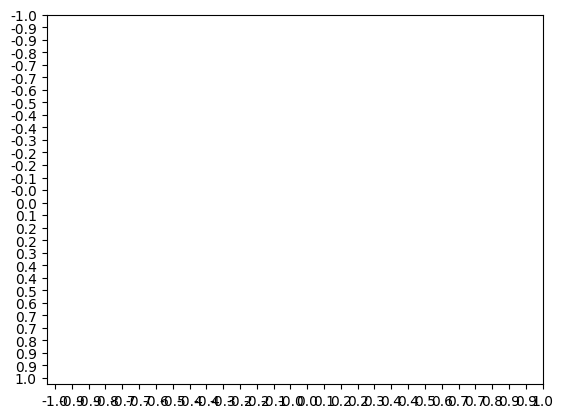

In [35]:
plt.xticks(pixel_range, sample_range_x)  # Label x-axis with latent space values
plt.yticks(pixel_range, sample_range_y)  # Label y-axis with latent space values


Sets x and y-axis labels to show which latent space point corresponds to each image.

(0.0, 1.0, 0.0, 1.0)

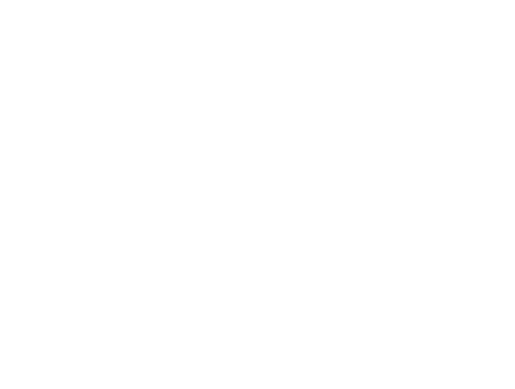

In [36]:
plt.xlabel("z[0]")  # Label x-axis as first latent dimension
plt.ylabel("z[1]")  # Label y-axis as second latent dimension
plt.axis("off")  # Remove axis lines for cleaner display


Labels the latent space axes z[0] and z[1].

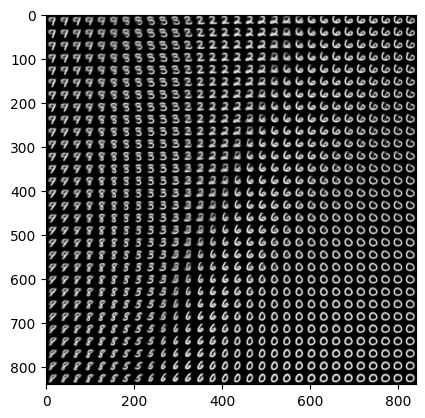

In [37]:
plt.imshow(figure, cmap="Greys_r")  # Display the grid of digits in grayscale


Displays the generated digit images in grayscale.

Interpretation of the Grid
The top-left and bottom-right corners have different digit styles.
As you move across the grid, digits morph smoothly between different numbers.
Some directions in the latent space may represent features like "five-ness" or "one-ness."
🌟 Summary
Step	Description
1. Import libraries	Import matplotlib for visualization
2. Define grid size	Create a 30x30 grid of 28x28 images
3. Create an empty canvas	Create a blank NumPy array to store generated digits
4. Generate a 2D grid of latent space points	Create x and y values from -1 to 1
5. Iterate over the grid	Generate an image for each latent space point
6. Display the images	Use plt.imshow() to visualize the results
This is how a Variational Autoencoder (VAE) learns a continuous latent space where small changes in latent variables smoothly transform one digit into another. 🚀